# **Portfolio Optimization with Risk Control using KKT and Lagrangian Duality**

## **Importing libraries**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


### **Defining portfolio tickers and fetching adjusted close prices**

In [ ]:

tickers = ['AAPL', 'TSLA', 'DIS', 'AMD', 'MSFT', 'AMZN', 'GOOG']
start_date = '2014-02-01'
end_date = '2023-02-11'

dfs = [yf.download(ticker, start=start_date, end=end_date)['Adj Close'] for ticker in tickers]
df = pd.concat(dfs, axis=1)
df.columns = tickers


df.dropna(inplace=True)


print("Columns in the DataFrame:", df.columns)
print(df.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Columns in the DataFrame: Index(['AAPL', 'TSLA', 'DIS', 'AMD', 'MSFT', 'AMZN', 'GOOG'], dtype='object')
                 AAPL       TSLA        DIS   AMD       MSFT       AMZN  \
Date                                                                      
2014-02-03  15.643744  11.807333  63.908840  3.33  30.551239  17.307501   
2014-02-04  15.870206  11.915333  64.876755  3.37  30.442383  17.397499   
2014-02-05  15.988736  11.628000  65.525040  3.31  29.998516  17.322500   
2014-02-06  16.081930  11.892000  68.994881  3.41  30.300007  17.729500   
2014-02-07  16.306915  12.435333  69.095337  3.47  30.618252  18.054001   

                 GOOG  
Date                   
2014-02-03  28.160780  
2014-02-04  28.278299  
2014-02-05  28.403521  
2014-02-06  28.819935  
2014-02-07  29.254234  


### **Annualized returns and covariance matrix**

In [ ]:

returns = df.pct_change().dropna()
expected_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252


print("Expected Returns:", expected_returns)
print("Covariance Matrix:", cov_matrix)


Expected Returns: AAPL    0.292961
TSLA    0.469302
DIS     0.094653
AMD     0.526225
MSFT    0.274757
AMZN    0.246981
GOOG    0.173432
dtype: float64
Covariance Matrix:           AAPL      TSLA       DIS       AMD      MSFT      AMZN      GOOG
AAPL  0.084482  0.068835  0.035574  0.072175  0.054658  0.054022  0.050182
TSLA  0.068835  0.314820  0.045846  0.112642  0.063457  0.074259  0.060042
DIS   0.035574  0.045846  0.074716  0.047558  0.036120  0.035735  0.036236
AMD   0.072175  0.112642  0.047558  0.351029  0.065902  0.076681  0.061408
MSFT  0.054658  0.063457  0.036120  0.065902  0.074904  0.058058  0.056420
AMZN  0.054022  0.074259  0.035735  0.076681  0.058058  0.110505  0.061183
GOOG  0.050182  0.060042  0.036236  0.061408  0.056420  0.061183  0.078207


### **Ploting cumulative returns for each stock**

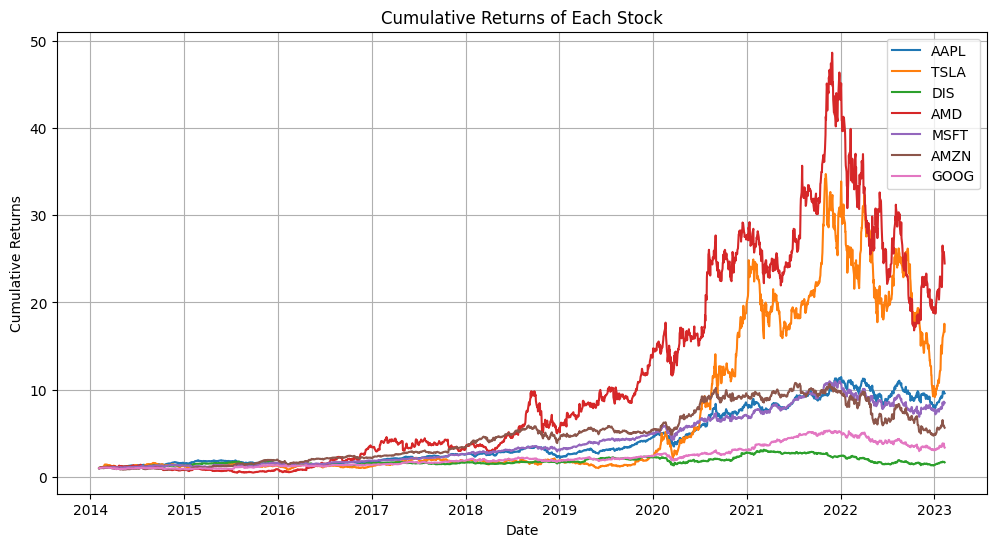

In [ ]:

cumulative_returns_stocks = (1 + returns).cumprod()
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(cumulative_returns_stocks[ticker], label=ticker)
plt.title('Cumulative Returns of Each Stock')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()


### **Correlation Matrix**

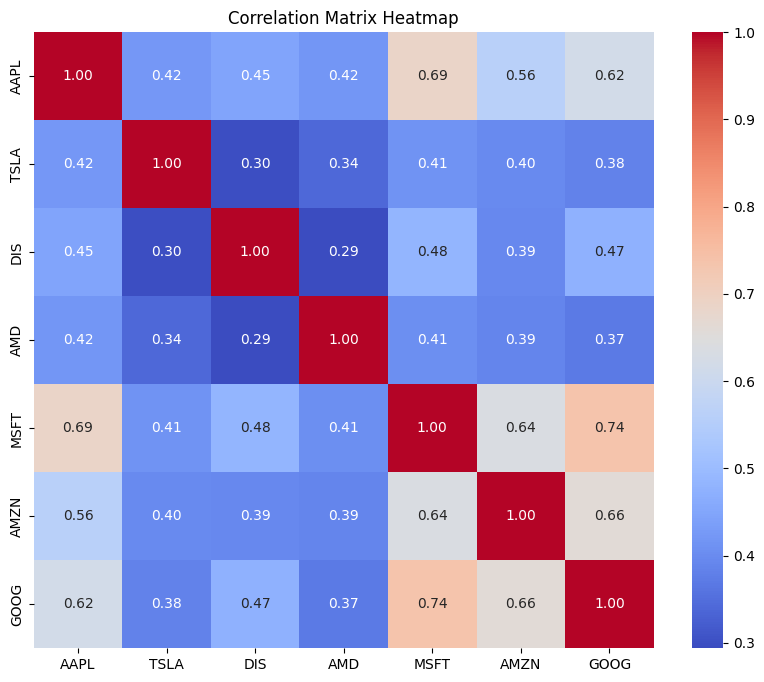

In [ ]:

import seaborn as sns
plt.figure(figsize=(10, 8))
correlation_matrix = returns.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            xticklabels=tickers, yticklabels=tickers)
plt.title('Correlation Matrix Heatmap')
plt.show()


### **Optimizing portfolio weights using KKT conditions**

In [ ]:

risk_aversion = 0.5


def lagrangian(weights, expected_returns, cov_matrix, risk_aversion):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return -portfolio_return + risk_aversion * portfolio_variance


def lagrangian_gradient(weights, expected_returns, cov_matrix, risk_aversion):
    grad_return = -expected_returns
    grad_variance = 2 * risk_aversion * np.dot(cov_matrix, weights)
    return grad_return + grad_variance


num_assets = len(df.columns)


initial_guess = num_assets * [1. / num_assets]


constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
bounds = tuple((0, 1) for _ in range(num_assets))


result = minimize(
    lagrangian,
    initial_guess,
    args=(expected_returns, cov_matrix, risk_aversion),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    jac=lagrangian_gradient
)

if result.success:
    optimized_weights = result.x
    print("Optimized Weights:", optimized_weights)
else:
    print("Optimization failed:", result.message)


Optimized Weights: [1.03623200e-17 4.11888833e-01 0.00000000e+00 5.88111167e-01
 0.00000000e+00 0.00000000e+00 1.32148814e-17]


### **Calculating optimized portfolio returns**

In [ ]:

optimized_portfolio = (returns * optimized_weights).sum(axis=1)


### **Histogram**

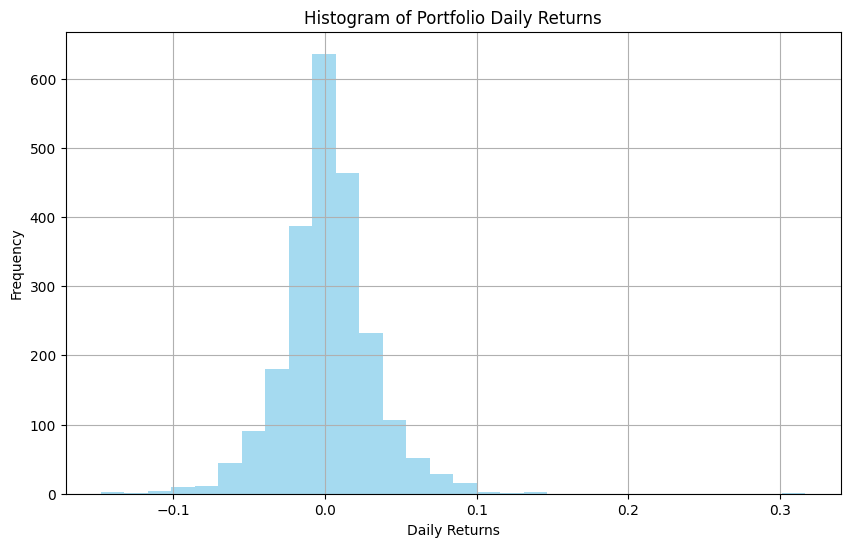

In [ ]:

plt.figure(figsize=(10, 6))
plt.hist(optimized_portfolio, bins=30, alpha=0.75, color='skyblue')
plt.title('Histogram of Portfolio Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid()
plt.show()


### **Generating random portfolios and ploting the Efficient Frontier**

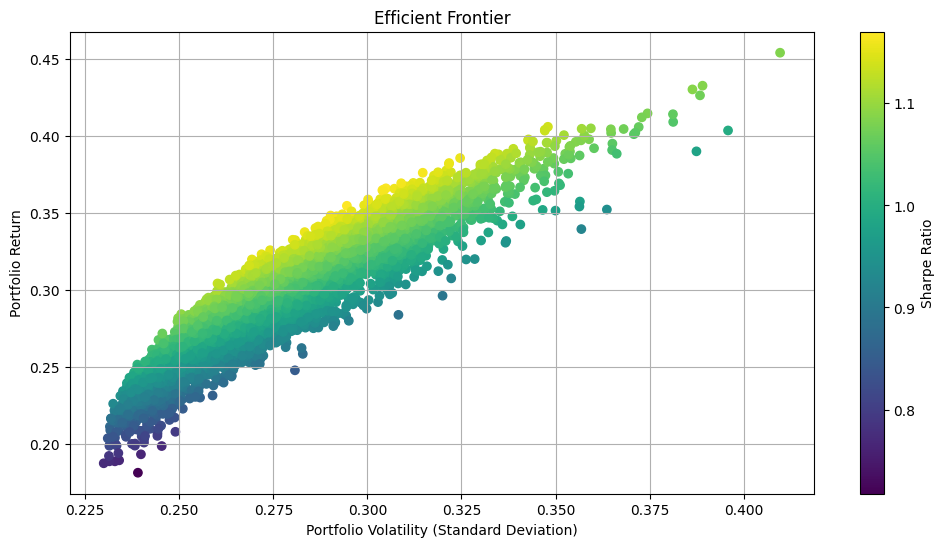

In [ ]:

num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    weights_record.append(weights)

    portfolio_return = np.dot(weights, expected_returns)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))

    results[0, i] = portfolio_return
    results[1, i] = np.sqrt(portfolio_variance)
    results[2, i] = (portfolio_return - 0.01) / results[1, i]


plt.figure(figsize=(12, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Portfolio Volatility (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid()
plt.show()


### **Calculating and ploting the Rolling Sharpe Ratio of the optimized portfolio**

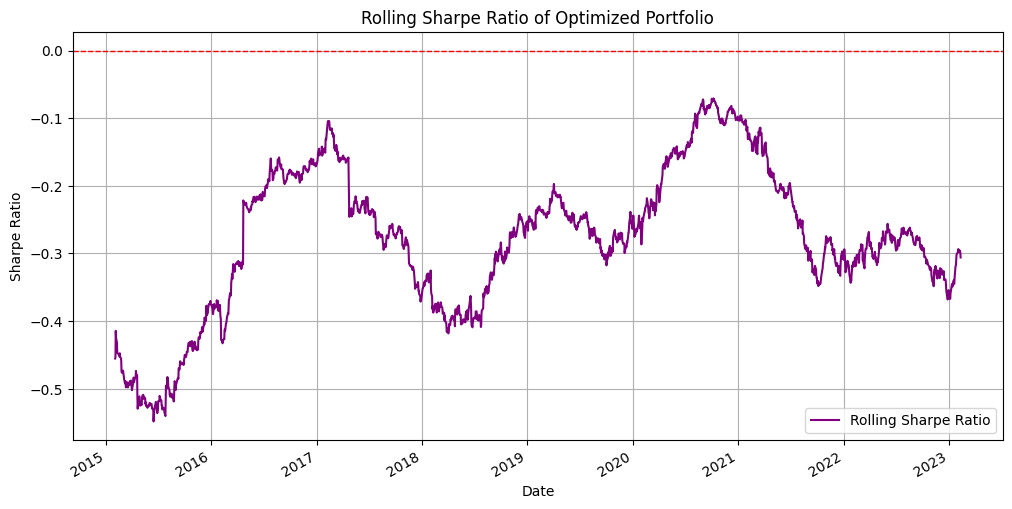

In [ ]:

rolling_sharpe = (returns.dot(optimized_weights) - 0.01).rolling(window=252).mean() / (returns.dot(optimized_weights).rolling(window=252).std())


plt.figure(figsize=(12, 6))
rolling_sharpe.plot(label='Rolling Sharpe Ratio', color='purple')
plt.title('Rolling Sharpe Ratio of Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.grid()
plt.legend()
plt.show()


### **Performance metrics**

In [ ]:

portfolio_return = np.dot(optimized_weights, expected_returns)
portfolio_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))


risk_free_rate = 0.01
excess_return = portfolio_return - risk_free_rate
sharpe_ratio = excess_return / portfolio_volatility


print(f"Expected Portfolio Return: {portfolio_return:.2f}")
print(f"Expected Portfolio Volatility: {portfolio_volatility:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Expected Portfolio Return: 0.50
Expected Portfolio Volatility: 0.48
Sharpe Ratio: 1.03


### **Sortino Ratio and Maximum Drawdown**

In [ ]:

downside_returns = np.minimum(0, returns.dot(optimized_weights))
expected_downside = np.mean(downside_returns)
sortino_ratio = (portfolio_return - 0) / np.std(downside_returns) if np.std(downside_returns) != 0 else 0


cumulative_returns = (1 + returns.dot(optimized_weights)).cumprod()
peak = cumulative_returns.cummax()
drawdown = (cumulative_returns - peak) / peak
max_drawdown = drawdown.min()


print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}")


Sortino Ratio: 29.05
Maximum Drawdown: -0.64


### **Compare optimized portfolio returns with AAPL benchmark**

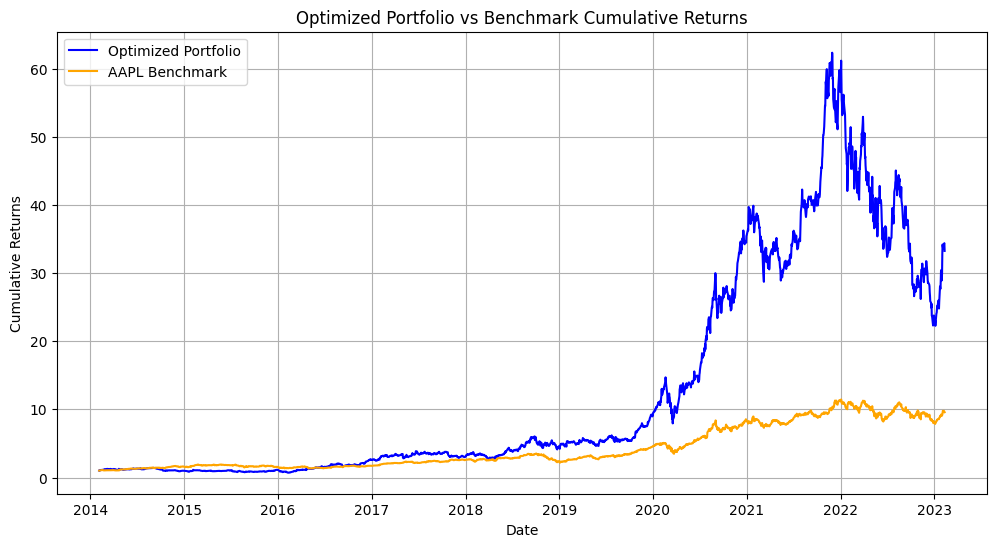

In [ ]:

if 'AAPL' in df.columns:

    benchmark = df['AAPL'].pct_change().dropna()


    optimized_portfolio_cumulative = (1 + returns.dot(optimized_weights)).cumprod()
    benchmark_cumulative = (1 + benchmark).cumprod()


    plt.figure(figsize=(12, 6))
    plt.plot(optimized_portfolio_cumulative, label='Optimized Portfolio', color='blue')
    plt.plot(benchmark_cumulative, label='AAPL Benchmark', color='orange')
    plt.title('Optimized Portfolio vs Benchmark Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("AAPL data not found in the DataFrame.")


### **Plotting Returns Distribution**

<Figure size 1000x600 with 0 Axes>

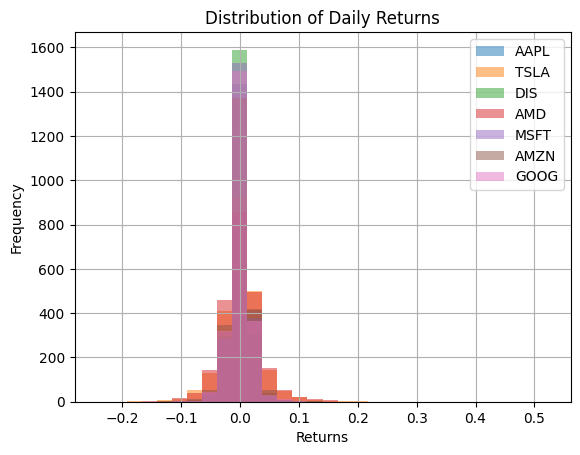

In [ ]:

plt.figure(figsize=(10, 6))
returns.plot(kind='hist', bins=30, alpha=0.5, legend=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid()
plt.show()


### **Plotting Portfolio Weights**

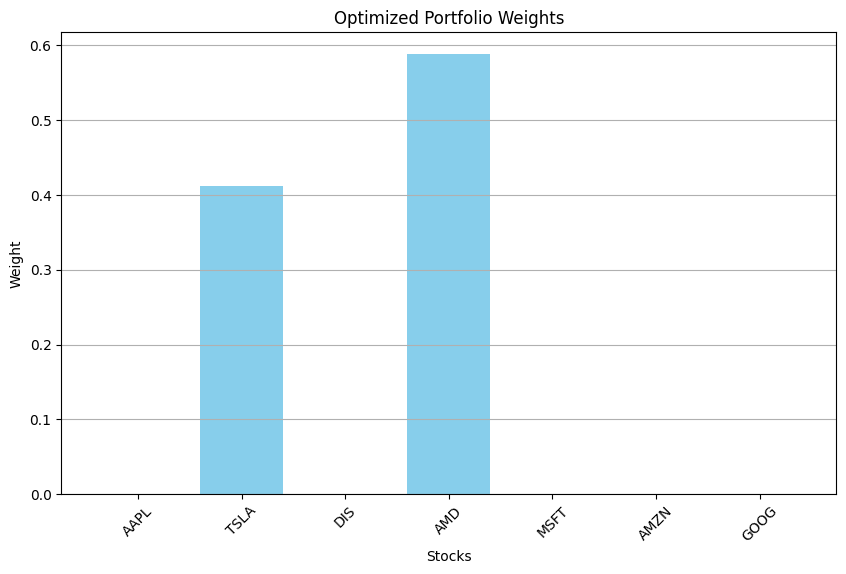

In [ ]:

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimized_weights, color='skyblue')
plt.title('Optimized Portfolio Weights')
plt.xlabel('Stocks')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
